In [14]:
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
import catboost as cb
import re
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
eth_ohlc = pd.read_csv('../data/transformed/ohlc/ethereum.csv')
eth_ohlc = eth_ohlc[:-1]
print(eth_ohlc.columns.tolist())

['date', 'open', 'high', 'low', 'close', 'volume', 'volume_eth', 'market_cap', 'tmw_percent_increase_to_avg_high_low', 'tmw_0_0_percent_increase_binary', 'tmw_0_25_percent_increase_binary', 'tmw_0_5_percent_increase_binary', 'tmw_0_75_percent_increase_binary', 'tmw_1_0_percent_increase_binary', 'tmw_1_25_percent_increase_binary', 'tmw_1_5_percent_increase_binary', 'tmw_1_75_percent_increase_binary', 'tmw_2_0_percent_increase_binary', 'tmw_2_25_percent_increase_binary', 'tmw_2_5_percent_increase_binary', 'tmw_2_75_percent_increase_binary', 'tmw_3_0_percent_increase_binary', 'tmw_0_25_percent_decrease_binary', 'tmw_0_5_percent_decrease_binary', 'tmw_0_75_percent_decrease_binary', 'tmw_1_0_percent_decrease_binary', 'perc_from_low_to_high', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'sma_2', 'rsi_2', 'volume_sma_2', 'volume_rsi_2', 'sp

In [15]:
eth_ohlc

,date,open,high,low,close,volume,volume_eth,market_cap,tmw_percent_increase_to_avg_high_low,tmw_0_0_percent_increase_binary,...,last_100_day_70th_to_80th_pct_spread_count,last_100_day_80th_to_90th_pct_spread_count,last_100_day_90th_to_95th_pct_spread_count,last_100_day_40th_pct_spread_count,last_100_day_50th_pct_spread_count,last_100_day_60th_pct_spread_count,last_100_day_70th_pct_spread_count,last_100_day_80th_pct_spread_count,last_100_day_90th_pct_spread_count,last_100_day_95th_pct_spread_count
0,2015-11-15,0.8912,0.9215,0.8750,0.9064,4.118000e+05,458365.0,6.720000e+07,0.033594,1.0,...,18.0,9.0,18.0,94.0,86.0,79.0,73.0,55.0,46.0,28.0
1,2015-11-16,0.9062,0.9447,0.8920,0.9290,6.209000e+05,676442.0,6.860000e+07,0.097955,1.0,...,18.0,9.0,18.0,94.0,86.0,78.0,72.0,54.0,45.0,27.0
2,2015-11-17,0.9249,1.0300,0.9058,1.0100,1.100000e+06,1183690.0,7.220000e+07,-0.009901,0.0,...,18.0,10.0,18.0,94.0,86.0,78.0,72.0,54.0,44.0,26.0
3,2015-11-18,0.9900,1.0100,0.9405,0.9900,6.811000e+05,691994.0,7.360000e+07,-0.007323,0.0,...,18.0,10.0,17.0,94.0,86.0,78.0,71.0,53.0,43.0,26.0
4,2015-11-19,0.9887,1.0100,0.9375,0.9555,4.435000e+05,455866.0,7.280000e+07,-0.015908,0.0,...,18.0,10.0,17.0,94.0,86.0,78.0,70.0,52.0,42.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3056,2024-04-16,3098.0000,3121.0000,3003.0000,3082.0000,1.710000e+10,5557389.0,3.757000e+11,-0.009896,0.0,...,10.0,4.0,3.0,45.0,32.0,26.0,17.0,7.0,3.0,0.0
3057,2024-04-17,3083.0000,3119.0000,2926.0000,2984.0000,1.550000e+10,5093979.0,3.722000e+11,0.030664,1.0,...,9.0,4.0,3.0,45.0,32.0,26.0,16.0,7.0,3.0,0.0
3058,2024-04-18,2986.0000,3087.0000,2960.0000,3064.0000,1.350000e+10,4453302.0,3.706000e+11,0.012076,1.0,...,9.0,4.0,3.0,44.0,31.0,26.0,16.0,7.0,3.0,0.0
3059,2024-04-19,3061.0000,3117.0000,2879.0000,3085.0000,1.740000e+10,5675824.0,3.746000e+11,0.024473,1.0,...,10.0,3.0,3.0,44.0,31.0,26.0,16.0,6.0,3.0,0.0


### Make heatmap of variable importance but grouped by price, volume, spread shit...

In [5]:
# Horizons
horizons = [2, 5, 10, 25, 50, 100]

# Initialize the results dictionary
correlation_lists = {horizon: {} for horizon in horizons}

# New labels for renaming
new_labels = [
    '40-50', '50-60', '60-70', '70-80', '80-90', '90-95', 
    '40+', '50+', '60+', '70+', '80+', '90+', '95+'
]

# Original column names without the prefixes and suffixes
base_labels = [
    '40th_to_50th_pct', '50th_to_60th_pct', '60th_to_70th_pct', 
    '70th_to_80th_pct', '80th_to_90th_pct', '90th_to_95th_pct',
    '40th_pct', '50th_pct', '60th_pct', '70th_pct', '80th_pct', '90th_pct', '95th_pct'
]

# Iterate over each horizon
for horizon in horizons:
    # Process each type
    for type_key in ['price_change_count', 'volume_change_count', 'spread_count']:
        # Generate dynamic original labels for the specific horizon and type
        original_labels = [f'last_{horizon}_day_{label}_{type_key}' for label in base_labels]
        label_map = dict(zip(original_labels, new_labels))

        # Generate correlation matrix for each predictor set
        corr_matrix = eth_ohlc[original_labels].corr()

        # Create a new DataFrame to manually add the corr matrix information with new labels
        new_corr_matrix = pd.DataFrame(index=new_labels, columns=new_labels)

        # Populate the new DataFrame by copying the values based on the label map
        for old_label in original_labels:
            new_row_label = label_map[old_label]
            for old_label_inner in original_labels:
                new_col_label = label_map[old_label_inner]
                new_corr_matrix.at[new_row_label, new_col_label] = corr_matrix.at[old_label, old_label_inner]

        # Store the full manually created correlation matrix
        correlation_lists[horizon][type_key] = new_corr_matrix


/var/folders/j7/ddlht6kj6dj0_8kvm5tg6q040000gn/T/ipykernel_33395/3371719993.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the right margin to make room for the colorbar


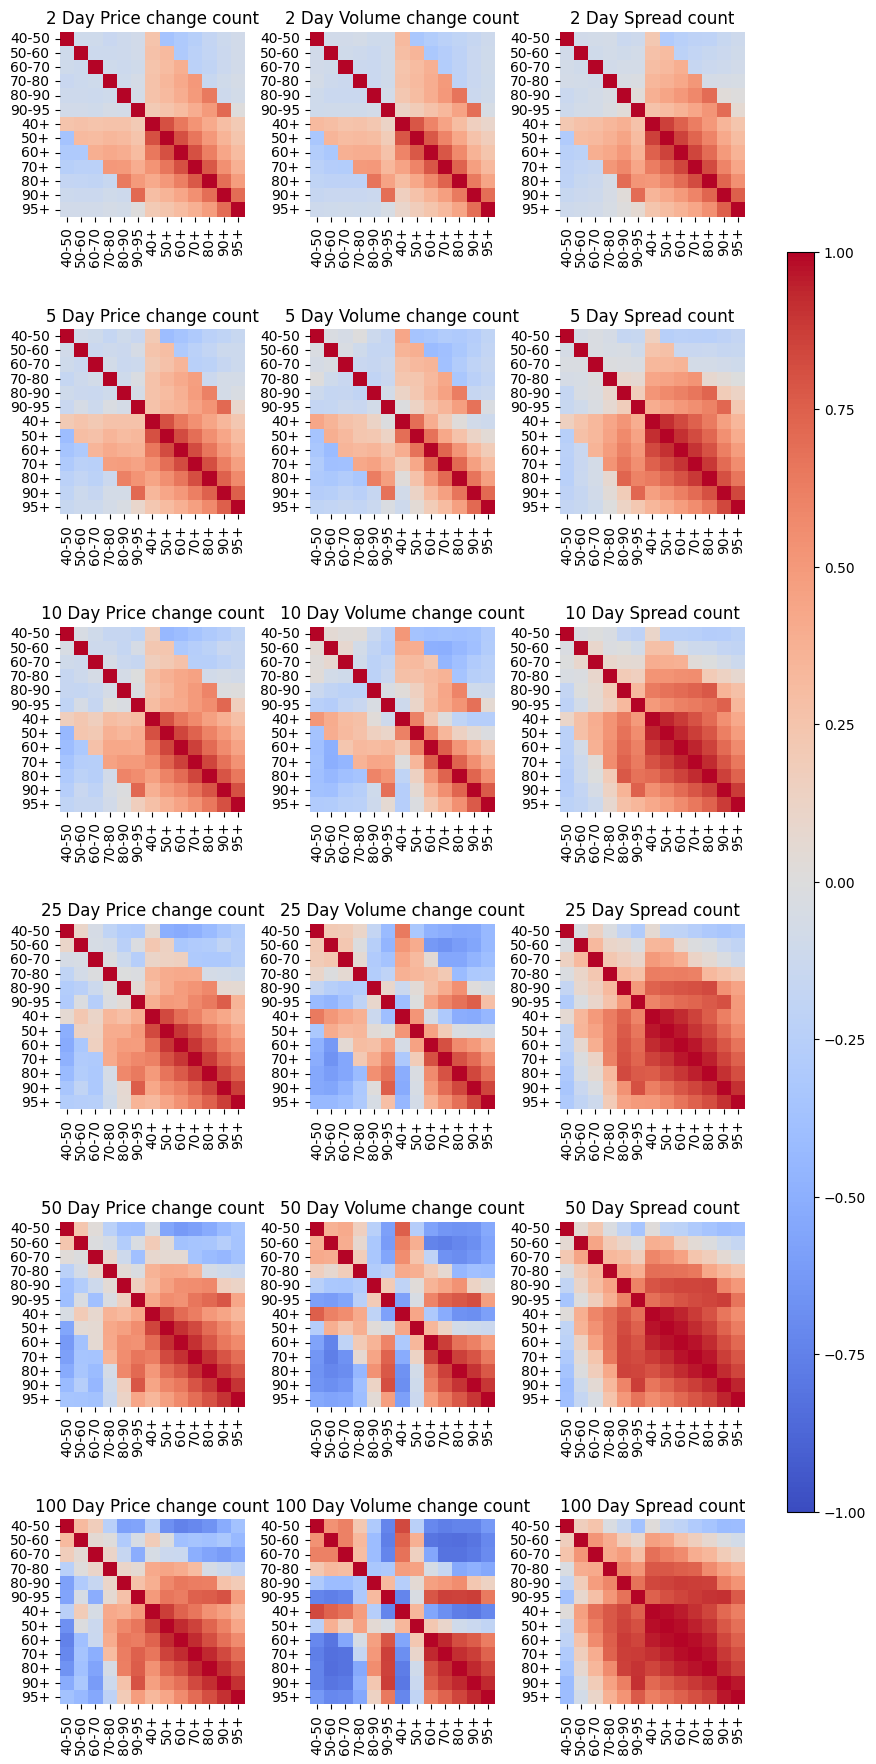

In [6]:
# Set up the plot grid
nrows = len(correlation_lists)
ncols = max(len(correlation_lists[h]) for h in correlation_lists)  # Determine the maximum number of types per horizon

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 3 * nrows))  # Adjust dimensions as needed

# Set the same color scale for all heatmaps
vmin, vmax = -1, 1  # Minimum and maximum values for the color scale

# Iterate over each row (horizon) and column (type)
for i, (horizon, types) in enumerate(correlation_lists.items()):
    for j, (type_key, corr_matrix) in enumerate(types.items()):
        # Ensure the matrix is in float format
        corr_matrix = corr_matrix.astype(float)
        
        # Access the specific subplot
        ax = axes[i][j]
        
        # Plot the heatmap with a fixed color scale and without a colorbar in each subplot
        sns.heatmap(corr_matrix, ax=ax, cmap='coolwarm', annot=False, square=True, vmin=vmin, vmax=vmax, cbar=False)
        
        # Set individual titles formatted with the number of days and the type of data
        ax.set_title(f'{horizon} Day {type_key.replace("_", " ").capitalize()}')

# Create an overall colorbar to the right of the grid
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # Adjust these values to position and size the colorbar
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm, cax=cbar_ax)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the right margin to make room for the colorbar
plt.show()


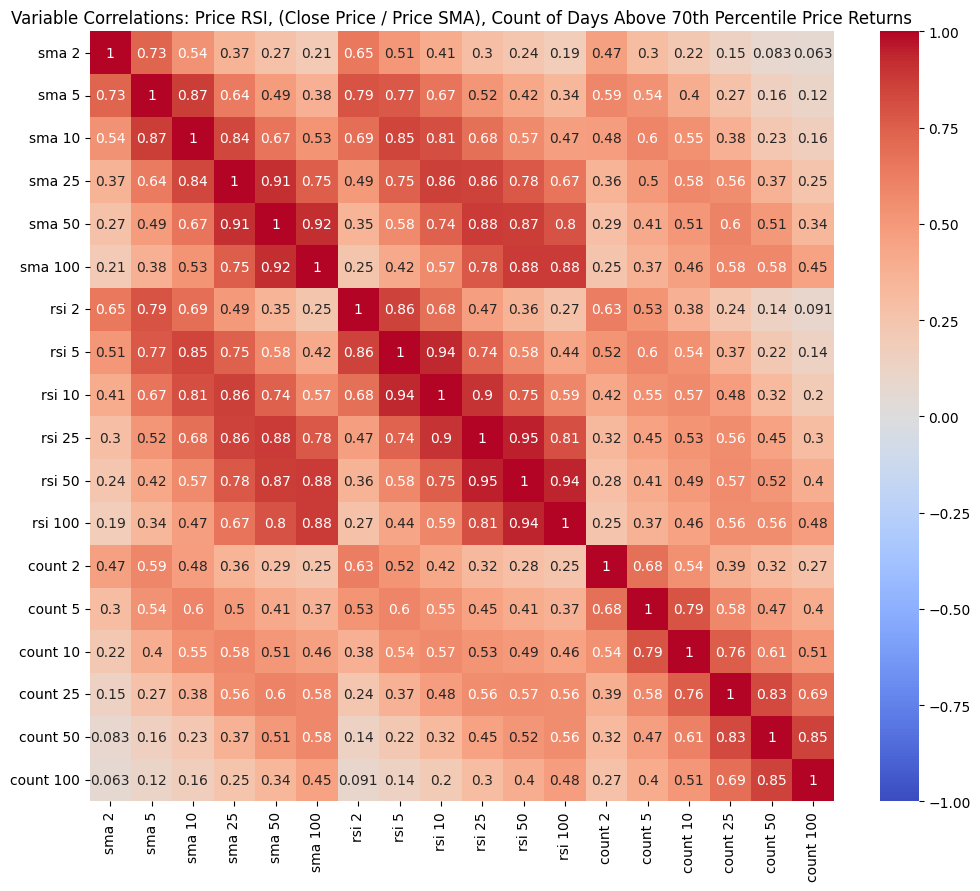

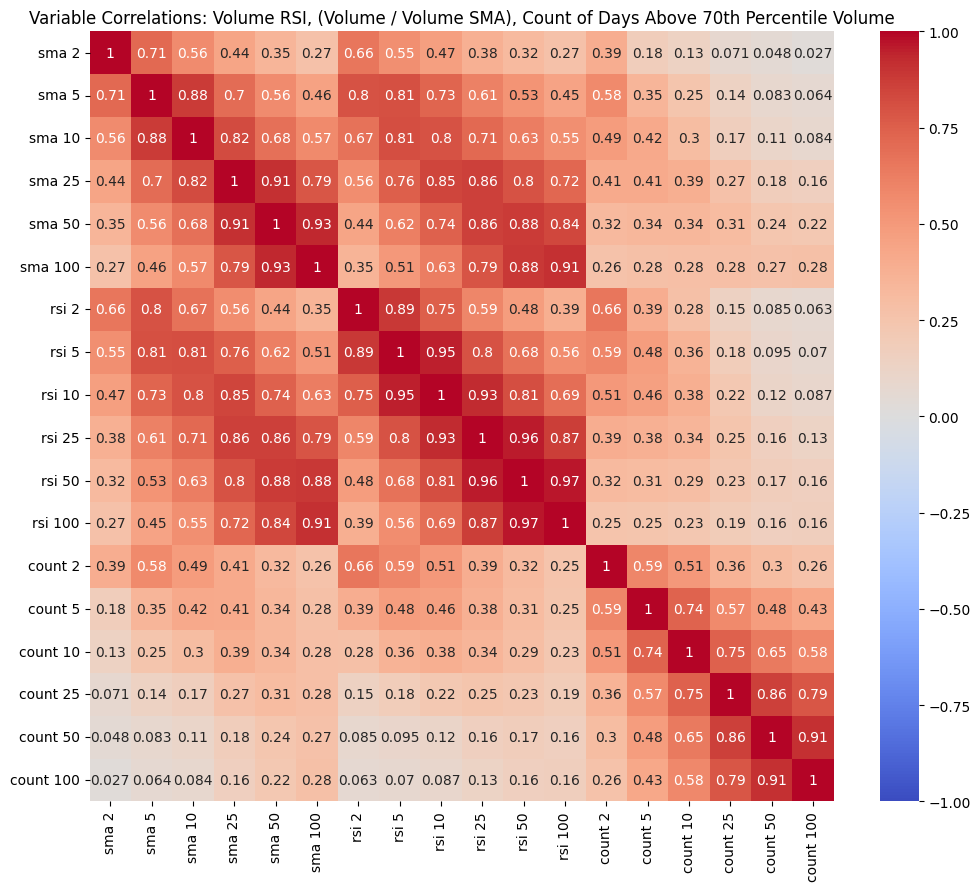

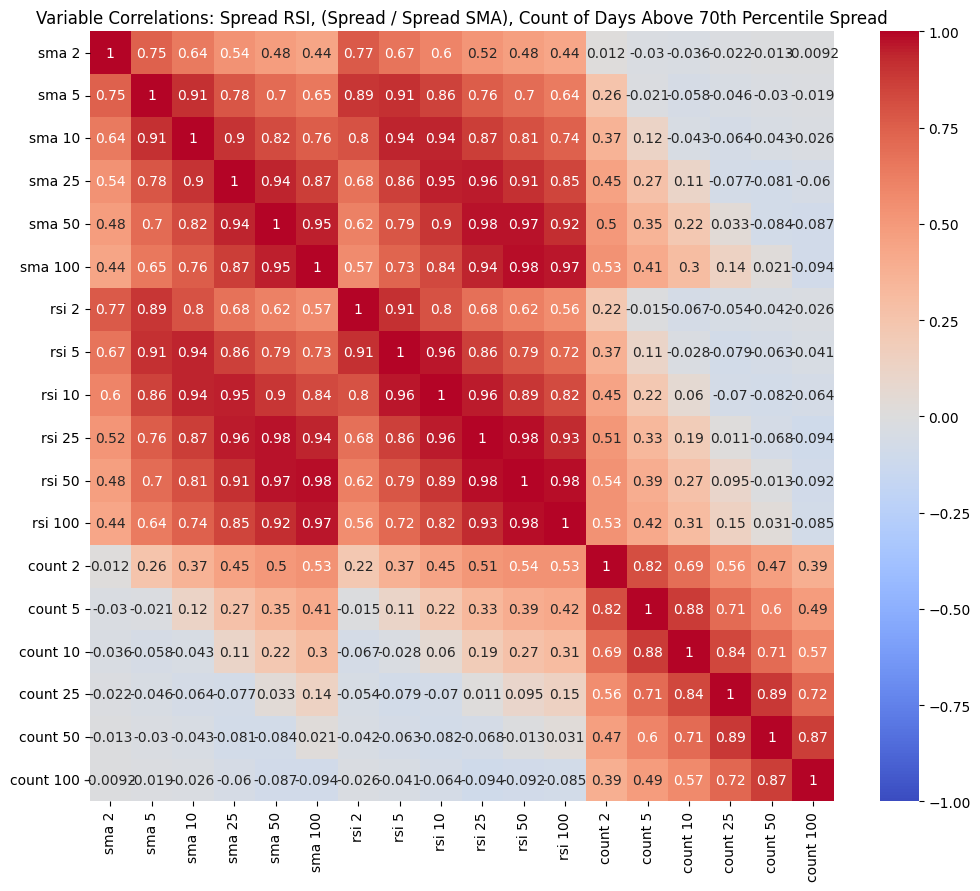

In [8]:
# Define a function to create and plot a heatmap
def plot_heatmap(df, columns, labels, title):
    # Calculate the correlation matrix for the specified columns
    corr_matrix = df[columns].corr()

    # Apply labels for better readability
    corr_matrix.columns = labels
    corr_matrix.index = labels

    # Create the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title(title)
    plt.show()

# List of horizons
horizons = [2, 5, 10, 25, 50, 100]

# Generate column names and labels for the first heatmap (Price Variables)
price_columns = [f"sma_{h}" for h in horizons] + [f"rsi_{h}" for h in horizons] + [f"last_{h}_day_70th_pct_price_change_count" for h in horizons]
price_labels = [f"sma {h}" for h in horizons] + [f"rsi {h}" for h in horizons] + [f"count {h}" for h in horizons]
plot_heatmap(eth_ohlc, price_columns, price_labels, 'Variable Correlations: Price RSI, (Close Price / Price SMA), Count of Days Above 70th Percentile Price Returns')

# Generate column names and labels for the second heatmap (Volume Variables)
volume_columns = [f"volume_sma_{h}" for h in horizons] + [f"volume_rsi_{h}" for h in horizons] + [f"last_{h}_day_70th_pct_volume_change_count" for h in horizons]
volume_labels = [f"sma {h}" for h in horizons] + [f"rsi {h}" for h in horizons] + [f"count {h}" for h in horizons]
plot_heatmap(eth_ohlc, volume_columns, volume_labels, 'Variable Correlations: Volume RSI, (Volume / Volume SMA), Count of Days Above 70th Percentile Volume')

# Generate column names and labels for the third heatmap (Spread Variables)
spread_columns = [f"spread_sma_{h}" for h in horizons] + [f"spread_rsi_{h}" for h in horizons] + [f"last_{h}_day_70th_pct_spread_count" for h in horizons]
spread_labels = [f"sma {h}" for h in horizons] + [f"rsi {h}" for h in horizons] + [f"count {h}" for h in horizons]
plot_heatmap(eth_ohlc, spread_columns, spread_labels, 'Variable Correlations: Spread RSI, (Spread / Spread SMA), Count of Days Above 70th Percentile Spread')


### Variable Reduction Via LASSO Regression

In [22]:
predictors = []

horizons = [2,5,10,25,50,100] 

for horizon in horizons:
    
    # type 1
    for indicator in ['rsi', 'sma']:
        predictors.append(f'{indicator}_{horizon}')
    
    # type 2
    for indicator in ['rsi', 'sma']:
        predictors.append(f'volume_{indicator}_{horizon}')

    # type 3
    for indicator in ['rsi', 'sma']:
        predictors.append(f'spread_{indicator}_{horizon}')

    # type 4
    price_change_counts = [
        f'last_{horizon}_day_40th_to_50th_pct_price_change_count',
        f'last_{horizon}_day_50th_to_60th_pct_price_change_count',
        f'last_{horizon}_day_60th_to_70th_pct_price_change_count',
        f'last_{horizon}_day_70th_to_80th_pct_price_change_count',
        f'last_{horizon}_day_80th_to_90th_pct_price_change_count',
        f'last_{horizon}_day_90th_to_95th_pct_price_change_count',
        f'last_{horizon}_day_40th_pct_price_change_count',
        f'last_{horizon}_day_50th_pct_price_change_count',
        f'last_{horizon}_day_60th_pct_price_change_count',
        f'last_{horizon}_day_70th_pct_price_change_count',
        f'last_{horizon}_day_80th_pct_price_change_count',
        f'last_{horizon}_day_90th_pct_price_change_count',
        f'last_{horizon}_day_95th_pct_price_change_count'
    ]

    # type 5
    volume_change_counts = [
        f'last_{horizon}_day_40th_to_50th_pct_volume_change_count',
        f'last_{horizon}_day_50th_to_60th_pct_volume_change_count',
        f'last_{horizon}_day_60th_to_70th_pct_volume_change_count',
        f'last_{horizon}_day_70th_to_80th_pct_volume_change_count',
        f'last_{horizon}_day_80th_to_90th_pct_volume_change_count',
        f'last_{horizon}_day_90th_to_95th_pct_volume_change_count',
        f'last_{horizon}_day_40th_pct_volume_change_count',
        f'last_{horizon}_day_50th_pct_volume_change_count',
        f'last_{horizon}_day_60th_pct_volume_change_count',
        f'last_{horizon}_day_70th_pct_volume_change_count',
        f'last_{horizon}_day_80th_pct_volume_change_count',
        f'last_{horizon}_day_90th_pct_volume_change_count',
        f'last_{horizon}_day_95th_pct_volume_change_count'

    ]

    # type 6
    spread_change_counts = [
        f'last_{horizon}_day_40th_to_50th_pct_spread_count',
        f'last_{horizon}_day_50th_to_60th_pct_spread_count',
        f'last_{horizon}_day_60th_to_70th_pct_spread_count',
        f'last_{horizon}_day_70th_to_80th_pct_spread_count',
        f'last_{horizon}_day_80th_to_90th_pct_spread_count',
        f'last_{horizon}_day_90th_to_95th_pct_spread_count',
        f'last_{horizon}_day_40th_pct_spread_count',
        f'last_{horizon}_day_50th_pct_spread_count',
        f'last_{horizon}_day_60th_pct_spread_count',
        f'last_{horizon}_day_70th_pct_spread_count',
        f'last_{horizon}_day_80th_pct_spread_count',
        f'last_{horizon}_day_90th_pct_spread_count',
        f'last_{horizon}_day_95th_pct_spread_count'
    ]

    predictors.extend(price_change_counts)
    predictors.extend(volume_change_counts)
    predictors.extend(spread_change_counts)

months = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
predictors.extend(months)
weekdays = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
predictors.extend(weekdays)

In [23]:
len(predictors)

289

In [24]:
# model = RandomForestClassifier(n_estimators=250, min_samples_split=200, random_state=1)
# model = cb.CatBoostClassifier(iterations=300, learning_rate=.01, depth=6, verbose=False, random_seed=1)
model = LogisticRegression(penalty='l1', C=.1, solver='liblinear', random_state=1, max_iter=1000)


response_var = 'tmw_1_0_percent_increase_binary'

In [20]:
def get_lasso_betas_along_sliding_window(model, data, response_var, predictors, len_window, len_shift, len_test):
    all_lasso_models_and_scores = []

    # Iterate through the dataset
    for i in range(0, len(data) - len_window, len_shift):
        train = data.iloc[i:i + len_window]
        test_end_idx = i + len_window + len_test
        test = data.iloc[i + len_window:min(test_end_idx, len(data))]  # Use remaining data if less than len_test

        # Create a new instance of the model for each iteration
        new_model = clone(model)  # Assuming you're using sklearn, clone the model

        # Fit the new model on the training set
        new_model.fit(train[predictors], train[response_var])

        # Predict using the test set
        predictions = new_model.predict(test[predictors])
        predictions = [1 if x >= 0.55 else 0 for x in predictions]
        precision = precision_score(test[response_var], predictions, zero_division=0)

        # Append results to the list
        all_lasso_models_and_scores.append({
            'model': new_model,
            'precision_score': precision,
            'train_start_date': train['date'].iloc[0],
            'train_end_date': train['date'].iloc[-1],
            'train_len': len(train),
            'test_start_date': test['date'].iloc[0],
            'test_end_date': test['date'].iloc[-1],
            'test_len': len(test),
        })

    return all_lasso_models_and_scores

In [33]:
lasso_results = get_lasso_betas_along_sliding_window(model=model, 
                                                     data=eth_ohlc, 
                                                     response_var=response_var, 
                                                     predictors=predictors, 
                                                     len_window=700, 
                                                     len_shift=30, 
                                                     len_test=90)

In [34]:
lasso_results

[{'model': LogisticRegression(C=0.1, max_iter=1000, penalty='l1', random_state=1,
                     solver='liblinear'),
  'precision_score': 0.5161290322580645,
  'train_start_date': '2015-11-15',
  'train_end_date': '2017-10-14',
  'train_len': 700,
  'test_start_date': '2017-10-15',
  'test_end_date': '2018-01-12',
  'test_len': 90},
 {'model': LogisticRegression(C=0.1, max_iter=1000, penalty='l1', random_state=1,
                     solver='liblinear'),
  'precision_score': 0.7272727272727273,
  'train_start_date': '2015-12-15',
  'train_end_date': '2017-11-13',
  'train_len': 700,
  'test_start_date': '2017-11-14',
  'test_end_date': '2018-02-11',
  'test_len': 90},
 {'model': LogisticRegression(C=0.1, max_iter=1000, penalty='l1', random_state=1,
                     solver='liblinear'),
  'precision_score': 0.5714285714285714,
  'train_start_date': '2016-01-14',
  'train_end_date': '2017-12-13',
  'train_len': 700,
  'test_start_date': '2017-12-14',
  'test_end_date': '2018-0

In [35]:
def get_frequently_selected_vars(lasso_data, var_proportion_among_windows_greater):

    coefficients = {'Variable Name': predictors}

    for result in lasso_data:
        model = result['model']
        betas = model.coef_
        betas = betas[0]
        date_range = f"{result['train_start_date']} to {result['train_end_date']}"
        coefficients[date_range] = list(betas)  # Make sure to convert numpy arrays to lists

    df_coefficients = pd.DataFrame(coefficients)

    num_models = len(lasso_data)
    df_coefficients['Non-zero Coeff Proportion'] = df_coefficients.iloc[:, 1:].apply(lambda row: np.count_nonzero(row) / num_models, axis=1)

    df_non_zero_betas = df_coefficients[df_coefficients['Non-zero Coeff Proportion'] > var_proportion_among_windows_greater]
    df_non_zero_betas = df_non_zero_betas.reset_index(drop=True)

    return df_non_zero_betas

In [36]:
all_vars = get_frequently_selected_vars(lasso_data=lasso_results, 
                                                var_proportion_among_windows_greater=-1)

In [37]:
all_vars

,Variable Name,2015-11-15 to 2017-10-14,2015-12-15 to 2017-11-13,2016-01-14 to 2017-12-13,2016-02-13 to 2018-01-12,2016-03-14 to 2018-02-11,2016-04-13 to 2018-03-13,2016-05-13 to 2018-04-12,2016-06-12 to 2018-05-12,2016-07-12 to 2018-06-11,...,2021-09-02 to 2023-08-02,2021-10-02 to 2023-09-01,2021-11-01 to 2023-10-01,2021-12-01 to 2023-11-01,2021-12-31 to 2023-12-01,2022-01-30 to 2023-12-31,2022-03-01 to 2024-01-30,2022-03-31 to 2024-02-29,2022-04-30 to 2024-03-30,Non-zero Coeff Proportion
0,rsi_2,-0.003552,-0.004942,-0.006525,-0.008657,-0.007857,-0.007803,-0.006853,-0.003340,-0.001867,...,-0.007916,-0.008451,-0.006578,-0.006971,-0.006096,-0.005702,-0.006854,-0.008272,-0.007645,0.987342
1,sma_2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,volume_rsi_2,-0.007690,-0.009310,-0.011197,-0.016692,-0.011135,-0.008769,-0.006717,-0.008708,-0.012709,...,0.000000,-0.000531,-0.002889,-0.000364,-0.002161,0.000000,-0.001157,-0.003735,-0.007052,0.886076
3,volume_sma_2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,spread_rsi_2,0.002803,0.001566,0.000724,0.006086,0.000000,0.000772,0.002607,0.004955,0.007016,...,0.001696,0.003820,0.008470,0.003866,0.004820,0.001811,0.005541,0.008913,0.012041,0.949367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,wednesday,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012658
285,thursday,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
286,friday,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.022421,-0.038948,-0.125628,-0.116078,0.088608
287,saturday,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [1]:
all_vars['Non-zero Coeff Proportion'].value_counts()

NameError: name 'all_vars' is not defined

### get sets of predicttors

In [39]:
unique_proportions = np.sort(all_vars['Non-zero Coeff Proportion'].unique())

with open('selected_variables.txt', 'w') as file:
    for proportion in unique_proportions:

        selected_vars = get_frequently_selected_vars(lasso_data=lasso_results, 
                                                     var_proportion_among_windows_greater=proportion)
        selected_vars_list = selected_vars['Variable Name'].tolist()

        variable_line = f"{proportion:.4f}, {len(selected_vars_list)}, {selected_vars_list}\n"

        if len(selected_vars_list) > 0:
            file.write(variable_line)
            print(variable_line) 

0.0000, 211, ['rsi_2', 'volume_rsi_2', 'spread_rsi_2', 'last_2_day_50th_to_60th_pct_price_change_count', 'last_2_day_80th_to_90th_pct_price_change_count', 'last_2_day_60th_pct_price_change_count', 'last_2_day_70th_pct_price_change_count', 'last_2_day_50th_to_60th_pct_volume_change_count', 'last_2_day_60th_to_70th_pct_volume_change_count', 'last_2_day_70th_to_80th_pct_volume_change_count', 'last_2_day_40th_pct_volume_change_count', 'last_2_day_60th_pct_volume_change_count', 'last_2_day_70th_pct_volume_change_count', 'last_2_day_80th_pct_volume_change_count', 'last_2_day_60th_to_70th_pct_spread_count', 'last_2_day_70th_to_80th_pct_spread_count', 'last_2_day_80th_to_90th_pct_spread_count', 'last_2_day_40th_pct_spread_count', 'last_2_day_60th_pct_spread_count', 'last_2_day_70th_pct_spread_count', 'rsi_5', 'volume_rsi_5', 'spread_rsi_5', 'last_5_day_40th_to_50th_pct_price_change_count', 'last_5_day_50th_to_60th_pct_price_change_count', 'last_5_day_60th_to_70th_pct_price_change_count', 'last